In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob,os
import scipy.stats as stats
import math
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import tqdm
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GlobalMaxPool1D, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b = True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis = -1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads):
        
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm = [0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm = [0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights
    
def gelu(x):
    """Gaussian Error Linear Unit.
    This is a smoother version of the RELU.
    Original paper: https://arxiv.org/abs/1606.08415
    refer : https://github.com/google-research/bert/blob/bee6030e31e42a9394ac567da170a89a98d2062f/modeling.py#L264
    Args:
        x: float Tensor to perform activation.
    Returns:
        `x` with the GELU activation applied.
    """
    cdf = 0.5 * (1.0 + tf.tanh(
        (np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf

def point_wise_feed_forward_network(d_model, dff):
    
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation = gelu),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

class EncoderLayer(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training = training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training = training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

class TransformerEncoder(tf.keras.layers.Layer):
    
    def __init__(self, num_layers, d_model, num_heads, dff, rate = 0.1):
        
        super(TransformerEncoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate

        self.embedding = tf.keras.layers.Dense(self.d_model)

        self.enc_layers = [EncoderLayer(self.d_model, self.num_heads, self.dff, self.rate) 
                           for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(self.rate)
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'dropout': self.dropout,
        })
        return config

    def call(self, x, training, mask = None):

        seq_len = tf.shape(x)[1]

        x = self.embedding(x)

        x = self.dropout(x, training = training)

        for i in range(self.num_layers):

            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)
    
def create_Transformer(num_columns, num_layers, d_model, num_heads, dff, dropout_rate):
    # d_model: Embedding depth of the model.
    # num_heads: Number of heads for Multi-head attention. d_model % num_heads = 0
    # dff: Depth of the point wise feed-forward network
    
    inp = tf.keras.layers.Input(shape = (num_columns, ))
    x = tf.keras.layers.Reshape((1, num_columns))(inp)
    
    x = TransformerEncoder(num_layers, d_model, num_heads, dff, dropout_rate)(x)[:, 0, :]
            
    out = tfa.layers.WeightNormalization(tf.keras.layers.Dense(1, activation = 'sigmoid'))(x)
    
    model = tf.keras.models.Model(inputs = inp, outputs = out)
    
    model.compile(loss="mae", optimizer="adam")
    
    return model

In [3]:
def get_file(path):                
    files =os.listdir(path)
    files.sort() 
    data_list= []
    for file in files:
        if not  os.path.isdir(path +file):     
            f_name = str(file)        
            tr = '\\'   
            filename = path + tr + f_name        
            data_list.append(filename)  
    return data_list 

def data_concat(path):
    data_list = get_file(path)
    l = []
    ll=[]
    n = []
    df_all=pd.DataFrame()

    for j in range(len(data_list)):
        print(data_list[j])
        df = pd.read_excel(data_list[j])
        ll.append(len(df))
        l.append([len(df),j])
        df=pd.DataFrame(df)
        df_all=pd.concat([df_all,df],axis=0)

    df_all = df_all.reset_index(drop=True)
    df_all_recol=df_all[['GROUP_CODE','MODEL_NAME','ISSUE_DATE','RC_ID','FAILURE_STAGE','PRODUCT_ID']]
    print(df_all_recol.shape)
    return df_all_recol

# df_all_recol.to_csv('df_all_recol.csv',index=False)

In [4]:
path = r'D:\RQ售後庫存資源分配\rawdata_new'
df_all_recol_new = data_concat(path)
df_all_recol=pd.read_csv('df_all_recol.csv')
df_all_recol_all = pd.concat([df_all_recol, df_all_recol_new],axis=0).reset_index(drop=True)


D:\RQ售後庫存資源分配\rawdata_new\RQ_L3_RAWDATA_ISSUE_DATE_202103_20210403.xlsx
D:\RQ售後庫存資源分配\rawdata_new\RQ_L3_RAWDATA_ISSUE_DATE_202104_20210503.xlsx
D:\RQ售後庫存資源分配\rawdata_new\RQ_L3_RAWDATA_ISSUE_DATE_202105_20210603.xlsx
(136264, 6)


In [34]:
df_all_recol = df_all_recol_all.copy()

In [59]:
path = r'D:\RQ售後庫存資源分配'
RC_ID_dict = pd.read_excel(path+'\\all_data(1).xlsx',sheet_name='RC_ID對應的地區').dropna(axis=1, thresh=3)
RC_ID_mapping = pd.read_excel(path+'\\all_data(1).xlsx',sheet_name='RC_ID mapping')
APPLICATION_dict = pd.read_excel(path+'\\all_data(1).xlsx',sheet_name='APPLICATION').iloc[:,:2]
RC_keep = RC_ID_dict[(RC_ID_dict['RC ID_分類表']!='虛擬_RC')&(RC_ID_dict['RC ID_分類表']!='異常大量退返')]['RC_ID']
APPLICATION_dict_keep = APPLICATION_dict['Code']


df_all_recol.replace(list(RC_ID_mapping['轉換前']), list(RC_ID_mapping['轉換後']), inplace=True)
df_all_recol = df_all_recol[(df_all_recol.PRODUCT_ID!='FFFFFFFFFFFFF')&
                            (df_all_recol.RC_ID.isin(RC_keep))].reset_index(drop=True)
df_all_recol = df_all_recol[['GROUP_CODE','ISSUE_DATE','RC_ID','FAILURE_STAGE','PRODUCT_ID']].dropna()
df_all_recol.loc[df_all_recol['FAILURE_STAGE']=='FR','FS']='FR'
df_all_recol.loc[df_all_recol['FAILURE_STAGE']!='FR','FS']='LR'
df_all_recol['ISSUE_DATE'] = pd.to_datetime(df_all_recol['ISSUE_DATE'], format='%Y-%m-%d')
df_all_recol['year_month'] = df_all_recol['ISSUE_DATE'].dt.strftime('%Y-%m')
df_all_recol['count']=1
df_all_recol_ASUS = df_all_recol.copy()
ASUS_LR = df_all_recol_ASUS[['GROUP_CODE', 'RC_ID', 'FAILURE_STAGE', 'PRODUCT_ID',
       'FS', 'year_month', 'count']]
df_ASUS_pivot = ASUS_LR.pivot_table(values='count', index='year_month',
                                    columns=['GROUP_CODE','FS','PRODUCT_ID','RC_ID'], aggfunc='count')
df_ASUS_all_pivot = ASUS_LR.pivot_table(values='count', index='year_month',
                                        columns=['GROUP_CODE','FS','PRODUCT_ID'], aggfunc='count')
df_ASUS_pivot.fillna(0,inplace=True)
df_ASUS_all_pivot.fillna(0,inplace=True)
df_ASUS_pivot_rollsum = df_ASUS_pivot.rolling(4).sum()
df_ASUS_all_pivot_rollsum = df_ASUS_all_pivot.rolling(4).sum()

df_pivot_v1 = (df_ASUS_pivot_rollsum/df_ASUS_all_pivot_rollsum).iloc[3:,:].transpose().reset_index()
dt_col = df_pivot_v1.columns[df_pivot_v1.columns.str.contains('20')]
df_pivot_v1[dt_col[0]]=df_pivot_v1[dt_col[0]].fillna(0)
df_pivot_v1[dt_col] = df_pivot_v1[dt_col].transpose().fillna(method='ffill').transpose()
train = df_pivot_v1.drop(columns=['PRODUCT_ID'])


In [63]:
month_col = train.columns[train.columns.str.contains('20')]
train_col=['FS']
train_col.extend(month_col)
train=train[train_col]
feature_col = train.columns[~train.columns.str.contains('20')]

data_monthly = train[month_col]

fix = train[feature_col]
step=12
data_stack=pd.DataFrame()
creat_col=['t_11','t_10','t_9','t_8','t_7','t_6','t_5','t_4','t_3','t_2','t_1','t','y']
creat_col=creat_col[-(step+1):]

for i in range(data_monthly.shape[1]-step):
#     print(i)
    data_12 = pd.concat([fix,data_monthly.iloc[:,0+i:step+1+i]],axis=1)
    data_12.columns=list(feature_col)+creat_col
    data_stack=pd.concat([data_stack,data_12])

data_stack=pd.get_dummies(data_stack,dtype='int64')

recent_data = data_stack.iloc[-(train.shape[0]):,1:]
train_x=data_stack.iloc[:-(train.shape[0])].drop(['y'],axis=1)
train_y=data_stack.iloc[:-(train.shape[0])].y
chg_x=data_stack.iloc[-(train.shape[0]):].drop(['y'],axis=1)
chg_y=data_stack.iloc[-(train.shape[0]):].y

train_x.shape, chg_x.shape, recent_data.shape

((127048, 14), (15881, 14), (15881, 14))

In [47]:
X_std = train_x.copy()
X_train,X_test,y_train,y_test=train_test_split(X_std,train_y,test_size=0.2, random_state=77)
print('X_train Shape :',X_train.shape)
print('X_test Shape :',X_test.shape)
print('y_train Shape :',y_train.shape)
print('y_test Shape :',y_test.shape)

X_train Shape : (101638, 14)
X_test Shape : (25410, 14)
y_train Shape : (101638,)
y_test Shape : (25410,)


In [48]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((101638, 14), (25410, 14), (101638,), (25410,))

In [49]:
# - num_layers: 決定要有幾個 EncoderLayers, 前面影片中的 `N`

model = create_Transformer(X_std.shape[1], num_layers=4, d_model=16, num_heads=8, dff=8, dropout_rate=0.1)
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 14)             0         
_________________________________________________________________
transformer_encoder_3 (Trans (None, None, 16)          5968      
_________________________________________________________________
tf_op_layer_strided_slice_3  [(None, 16)]              0         
_________________________________________________________________
weight_normalization_3 (Weig (None, 1)                 36        
Total params: 6,004
Trainable params: 5,986
Non-trainable params: 18
_________________________________________________________________


In [50]:
from tensorflow.keras.callbacks import LearningRateScheduler

def step_decay(epoch):
    initial_lrate = 0.0025 # 初始化學習率
    drop = 0.2 # 每次遞減率
    epochs_drop = 15 # 每 10 個 epochs 降低一次學習率
    lrate = initial_lrate * tf.math.pow(drop, tf.math.floor((1+epoch)/epochs_drop))
    return lrate
lr_schedule = LearningRateScheduler(step_decay, verbose=1)
callback = EarlyStopping(monitor="val_loss", patience=20, verbose=1, mode="auto", restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 500, batch_size = 64, 
                    callbacks = [callback, lr_schedule])


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.0025, shape=(), dtype=float32).
Epoch 1/500
1589/1589 [==============================] - 6s 4ms/step - loss: 0.0717 - val_loss: 0.0551

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0025, shape=(), dtype=float32).
Epoch 2/500
1589/1589 [==============================] - 5s 3ms/step - loss: 0.0540 - val_loss: 0.0494

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0025, shape=(), dtype=float32).
Epoch 3/500
1589/1589 [==============================] - 5s 3ms/step - loss: 0.0525 - val_loss: 0.0508

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0025, shape=(), dtype=float32).
Epoch 4/500
1589/1589 [==============================] - 5s 3ms/step - loss: 0.0520 - val_loss: 0.0523

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0025, shape=(), dtype=float32).
Epoch 5/500
1589/1589 [==============================] - 5

1589/1589 [==============================] - 6s 3ms/step - loss: 0.0464 - val_loss: 0.0454

Epoch 00040: LearningRateScheduler reducing learning rate to tf.Tensor(0.000100000005, shape=(), dtype=float32).
Epoch 40/500
1589/1589 [==============================] - 6s 4ms/step - loss: 0.0464 - val_loss: 0.0453

Epoch 00041: LearningRateScheduler reducing learning rate to tf.Tensor(0.000100000005, shape=(), dtype=float32).
Epoch 41/500
1589/1589 [==============================] - 6s 4ms/step - loss: 0.0464 - val_loss: 0.0455

Epoch 00042: LearningRateScheduler reducing learning rate to tf.Tensor(0.000100000005, shape=(), dtype=float32).
Epoch 42/500
1589/1589 [==============================] - 6s 4ms/step - loss: 0.0463 - val_loss: 0.0454

Epoch 00043: LearningRateScheduler reducing learning rate to tf.Tensor(0.000100000005, shape=(), dtype=float32).
Epoch 43/500
1589/1589 [==============================] - 5s 3ms/step - loss: 0.0463 - val_loss: 0.0453

Epoch 00044: LearningRateScheduler r

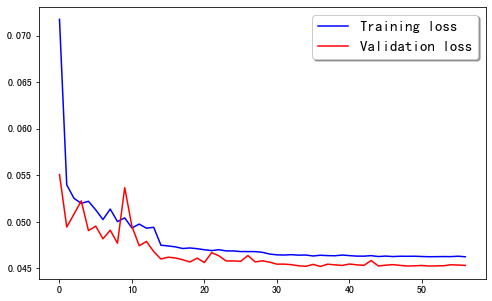

In [51]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="Validation loss")
ax.legend(loc='best', shadow=True, fontsize=15)

In [99]:
# model.save_weights("RQ_transformer_ffill_v1.h5")
# model.load_weights("RQ_transformer_ffill_v1.h5")

In [100]:
# all
y_head=model.predict(X_std)
print('-'*10+'all'+'-'*10)
print('R-sq: %.4f'%(r2_score(train_y,y_head)))
print('MAE: %.3f'%(mean_absolute_error(train_y,y_head)))

# test
y_head=model.predict(X_test)
print('-'*10+'test'+'-'*10)
print('R-sq: %.4f'%(r2_score(y_test,y_head)))
print('MAE: %.3f'%(mean_absolute_error(y_test,y_head)))

# last month
y_head=model.predict(chg_x)
print('-'*10+'last'+'-'*10)
print('R-sq: %.4f'%(r2_score(chg_y,y_head)))
print('MAE: %.3f'%(mean_absolute_error(chg_y,y_head)))

----------all----------
R-sq: 0.8673
MAE: 0.045
----------test----------
R-sq: 0.8656
MAE: 0.045
----------last----------
R-sq: 0.8916
MAE: 0.037


In [81]:
def model_pred(df_pivot_v1, y_head, NewColName='NewMonth'):
    pred_lastmonth = df_pivot_v1.loc[:,:'RC_ID']
    pred_lastmonth[NewColName]=y_head
    pred_lastmonth[NewColName] = round(pred_lastmonth[NewColName],1)
    return pred_lastmonth

In [84]:
pred_lastmonth = model_pred(df_pivot_v1, model.predict(chg_x), NewColName=dt_col[-1])

In [83]:
import datetime as dt
from dateutil.relativedelta import relativedelta

new_month = dt.datetime.strptime(dt_col[-1], "%Y-%m")+relativedelta(months=1)
new_monthName = new_month.strftime("%Y-%m")
PredNewMonth = model_pred(df_pivot_v1, model.predict(recent_data), NewColName=new_monthName)
PredNewMonth

year_month,GROUP_CODE,FS,PRODUCT_ID,RC_ID,2021-06
0,A NOVO,FR,GM215HCA3GE0S,PCZ,1.0
1,A NOVO,FR,GM215HCA3GF0S,PCZ,1.0
2,A NOVO,FR,GM215HCA3GL0S,PCZ,1.0
3,A NOVO,FR,GM215HCA3GU0S,PCZ,1.0
4,A NOVO,FR,GM215HGE2P20S,PCZ,1.0
...,...,...,...,...,...
15876,高照,LR,GS400HJ6E810S,HLM,1.0
15877,高照,LR,GS400HJ6E820S,HLM,1.0
15878,龍亭,LR,GS231AJ10140S,HL2,1.0
15879,龍亭,LR,GS350AJ10100S,HL2,1.0
